In [4]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

deployment = pd.read_parquet('../data/BAF_deployment_score.parquet')
train = pd.read_parquet('../data/BAF.parquet').loc[:deployment.index[0]-1,:]

current_expert_properties = pd.read_parquet(f'./expert_info/expert_properties.parquet')
current_w = pd.read_parquet(f'./expert_info/full_w_table.parquet')
current_deploy = pd.read_parquet(f'./expert_info/deployment_predictions.parquet')
current_train = pd.read_parquet(f'./expert_info/train_predictions.parquet')
current_perror = pd.read_parquet(f'./expert_info/p_of_error.parquet')
current_deployment_exp_X = pd.read_parquet(f'./transformed_data/X_deployment_experts.parquet')
current_train_exp_X = pd.read_parquet(f'./transformed_data/X_train_experts.parquet')

with open(f'../ml_model/model/model_properties.pickle', 'rb') as infile:
    ml_model_properties = pickle.load(infile)

ml_model_threshold = ml_model_properties['threshold']
ml_model_recall = 1 - ml_model_properties['fnr']
ml_model_fpr_diff = ml_model_properties['disparity']

pal = sns.color_palette(['C0','C2', 'C3'])
pal = pal.as_hex()

In [5]:
current_expert_properties['expert'].to_list()

new_names = []
for expert in current_expert_properties['expert'].to_list():
    if expert.split('#')[0] == 'regular':
        new_names.append('standard#' + expert.split('#')[1])
    else:
        new_names.append(expert)

In [6]:
temp = current_perror.loc[deployment.index, :]

temp_lp = temp.loc[deployment.loc[deployment['fraud_bool'] == 1].index,:]
temp_ln = temp.loc[deployment.loc[deployment['fraud_bool'] == 0].index, :]
temp_lp = temp_lp.iloc[:, np.arange(0,100,2)]
temp_ln = temp_ln.iloc[:, np.arange(1,101,2)]



In [7]:
temp_ln_sample = temp_ln.sample(n=10000)

In [8]:
def obtain_exp_class(exp):
    exp_type = exp.split('#')[0].split('_')[-1]
    if exp_type == 'regular':
        exp_type = 'standard'
    if exp_type == 'agreeing':
        exp_type = 'model_agreeing'
    return exp_type

melted_ln = temp_ln_sample.melt()
melted_lp = temp_lp.melt()
melted_ln['Group'] = melted_ln['variable'].apply(obtain_exp_class)
melted_lp['Group'] = melted_lp['variable'].apply(obtain_exp_class)

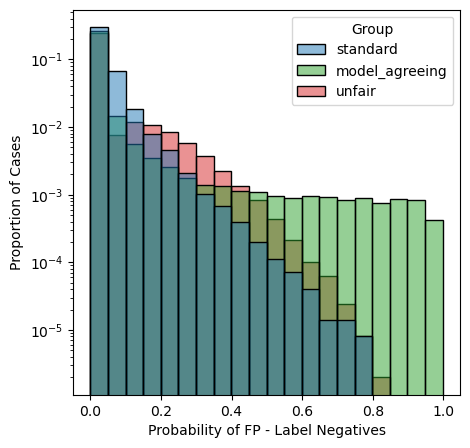

In [9]:
melted_ln
f, ax = plt.subplots(figsize=(5, 5))
sns.histplot(data = melted_ln, x = 'value', hue = 'Group', stat = 'probability', bins = 20, log_scale = (False,10), palette=["C0", "C2", "C3"])
plt.ylabel('Proportion of Cases')

plt.xlabel('Probability of FP - Label Negatives')
plt.savefig("perror_dist_ln.pdf", format="pdf", bbox_inches="tight")

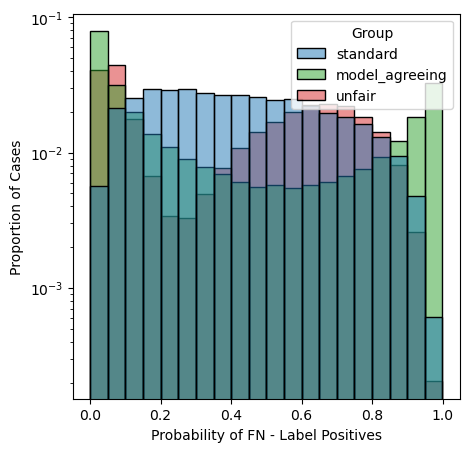

In [10]:
f, ax = plt.subplots(figsize=(5, 5))
g = sns.histplot(data = melted_lp, x = 'value', hue = 'Group', stat = 'probability', bins = 20, log_scale = (False,10), palette=["C0", "C2", "C3"])
plt.ylabel('Proportion of Cases')

plt.xlabel('Probability of FN - Label Positives')
plt.savefig("perror_dist_lp.pdf", format="pdf", bbox_inches="tight")

In [11]:
exp_list = current_deploy.columns.drop('model#0').to_list()

from sklearn.metrics import confusion_matrix

fpr_disparity = pd.DataFrame(index = exp_list, columns = ['target_fpr', 'fpr_train', 'fpr_train_y', 'fpr_train_o', 'fpr_deployment', 'fpr_deployment_y', 'fpr_deployment_o', 'target_fnr', 'fnr_train', 'fnr_train_y', 'fnr_train_o', 'fnr_deployment', 'fnr_deployment_y', 'fnr_deployment_o', 'disparity_train', 'disparity_deployment'])

old_index_dep = deployment.loc[deployment['customer_age'] > 50].index
yng_index_dep = deployment.loc[deployment['customer_age'] < 50].index

old_index_train = train.loc[train['customer_age'] > 50].index
yng_index_train = train.loc[train['customer_age'] < 50].index
for exp in exp_list:

    preds = current_deploy[exp]
    labels = deployment['fraud_bool']

    preds_o = current_deploy[exp].loc[old_index_dep]
    labels_o = deployment['fraud_bool'].loc[old_index_dep]

    preds_y = current_deploy[exp].loc[yng_index_dep]
    labels_y = deployment['fraud_bool'].loc[yng_index_dep]

    tn, fp, fn, tp = confusion_matrix(labels,preds).ravel()

    tn_o, fp_o, fn_o, tp_o = confusion_matrix(labels_o,preds_o).ravel()

    tn_y, fp_y, fn_y, tp_y = confusion_matrix(labels_y,preds_y).ravel()

    fpr_disparity.loc[exp, 'fpr_deployment'] = fp/(tn+fp)
    fpr_disparity.loc[exp, 'fpr_deployment_y'] = fp_y/(tn_y+fp_y)
    fpr_disparity.loc[exp, 'fpr_deployment_o'] = fp_o/(tn_o+fp_o)
    fpr_disparity.loc[exp, 'fnr_deployment'] = fn/(fn+tp)
    fpr_disparity.loc[exp, 'fnr_deployment_y'] = fn_y/(tp_y+fn_y)
    fpr_disparity.loc[exp, 'fnr_deployment_o'] = fn_o/(tp_o+fn_o)

    preds = current_train[exp]
    labels = train['fraud_bool']

    preds_o = current_train[exp].loc[old_index_train]
    labels_o = train['fraud_bool'].loc[old_index_train]

    preds_y = current_train[exp].loc[yng_index_train]
    labels_y = train['fraud_bool'].loc[yng_index_train]

    tn, fp, fn, tp = confusion_matrix(labels,preds).ravel()

    tn_o, fp_o, fn_o, tp_o = confusion_matrix(labels_o,preds_o).ravel()

    tn_y, fp_y, fn_y, tp_y = confusion_matrix(labels_y,preds_y).ravel()

    fpr_disparity.loc[exp, 'fpr_train'] = fp/(tn+fp)
    fpr_disparity.loc[exp, 'fpr_train_y'] = fp_y/(tn_y+fp_y)
    fpr_disparity.loc[exp, 'fpr_train_o'] = fp_o/(tn_o+fp_o)
    fpr_disparity.loc[exp, 'fnr_train'] = fn/(fn+tp)
    fpr_disparity.loc[exp, 'fnr_train_y'] = fn_y/(tp_y+fn_y)
    fpr_disparity.loc[exp, 'fnr_train_o'] = fn_o/(tp_o+fn_o)


fpr_disparity['disparity_train'] = fpr_disparity['fpr_train_o'] - fpr_disparity['fpr_train_y']
fpr_disparity['disparity_deployment'] = fpr_disparity['fpr_deployment_o'] - fpr_disparity['fpr_deployment_y']


In [12]:
fpr_disparity['target_fpr'] = current_expert_properties['fpr_base'].values
fpr_disparity['target_fnr'] = current_expert_properties['fnr_base'].values
fpr_disparity.to_parquet(f'./expert_info/fpr_disparity.parquet')
types = fpr_disparity.index.to_list()
groups = []
for expert in types:
    if expert.split('#')[0] == 'regular':
        groups.append('standard')
    else:
        groups.append(expert.split('#')[0])
  
fpr_disparity['group'] = groups

fpr_disparity['tpr_deployment'] = 1 - fpr_disparity['fnr_deployment']
fpr_disparity['target_tpr'] = 1 - fpr_disparity['target_fnr']

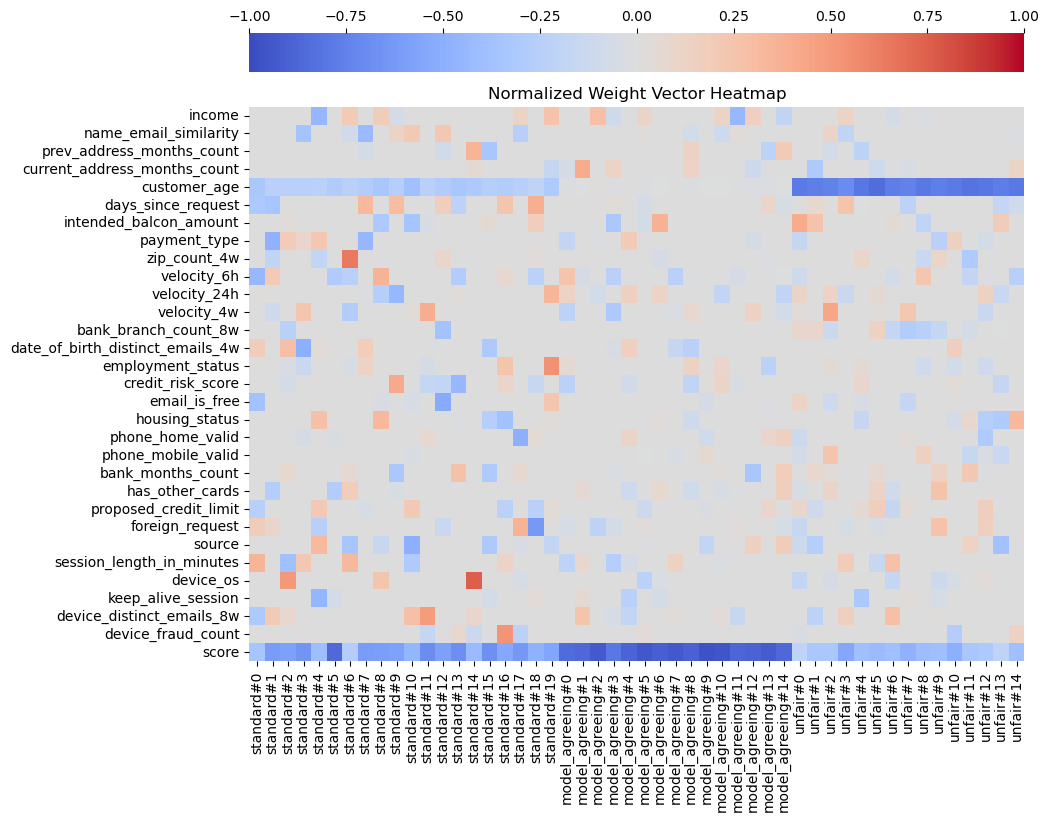

In [13]:
prop = pd.read_parquet('/mnt/home/jean.alves/Clean_May_copy/experts/expert_info_30_05_2023/full_w_table.parquet')

w = prop.drop(columns =['fp_intercept', 'fn_intercept', 'alpha'])
w.index = pd.Index(new_names)
w = w.div(np.sqrt(np.square(w).sum(axis=1)), axis = 0)

f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(w.T, robust=True, cmap = 'coolwarm', vmax = 1, vmin = -1, cbar_kws = dict(use_gridspec=False,location="top"))
plt.title("Normalized Weight Vector Heatmap")
plt.savefig("w_heatmap.pdf", format="pdf", bbox_inches="tight")
plt.show()

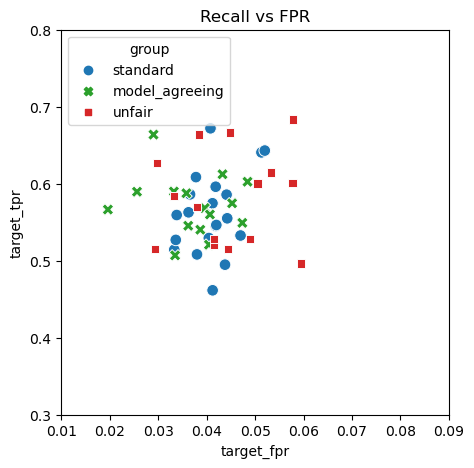

In [20]:
f, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=fpr_disparity, x='target_fpr', y='target_tpr', hue='group', style='group',  palette=["C0", "C2", "C3"], s = 70).set(title = 'Recall vs FPR')

plt.ylim([0.3,0.8])
plt.xlim([0.01, 0.09])
plt.savefig("Target_Performance.pdf", format="pdf", bbox_inches="tight")
plt.show()

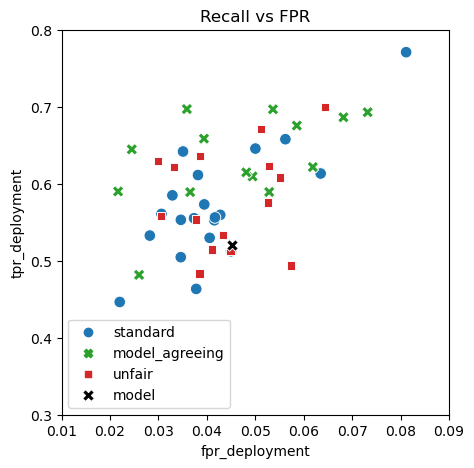

In [15]:
f, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=fpr_disparity, x='fpr_deployment', y='tpr_deployment', hue='group', style='group', s = 70, palette=["C0", "C2", "C3"])
fpr_model = 0.0451
tpr_model = 0.5206
sns.scatterplot(x= [fpr_model], y = [tpr_model], label = 'model', s = 70, color = 'black', marker = 'X').set(title = 'Recall vs FPR')
plt.ylim([0.3,0.8])
plt.xlim([0.01, 0.09])

plt.savefig("Deployment_Performance.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [16]:
exp_pred = current_deploy.drop(columns = 'model#0')
model_pred = (current_deploy['model#0'] > ml_model_threshold).astype(int)
labels = deployment['fraud_bool']
exp_pred_lp = exp_pred.loc[labels == 1]
exp_pred_ln = exp_pred.loc[labels == 0]
model_pred_lp = model_pred.loc[labels == 1]
model_pred_ln = model_pred.loc[labels == 0]

exp_corr_mod_fp = []
exp_corr_mod_fn = []
exp_fp_mod_corr = []
exp_fn_mod_corr = []

expert_correct_model_fp = pd.DataFrame(index = exp_pred_ln.index, columns = exp_pred_ln.columns)

expert_correct_model_fn = pd.DataFrame(index = exp_pred_lp.index, columns = exp_pred_lp.columns)

expert_fp_model_correct = pd.DataFrame(index = exp_pred_ln.index, columns = exp_pred_ln.columns)

expert_fn_model_correct = pd.DataFrame(index = exp_pred_lp.index, columns = exp_pred_lp.columns)

for exp in exp_pred.columns:
    expert_correct_model_fp[exp] = ((exp_pred_ln[exp] == 0) & (model_pred_ln == 1)).astype(int)
    expert_correct_model_fn[exp] = ((exp_pred_lp[exp] == 1) & (model_pred_lp == 0)).astype(int)
    expert_fp_model_correct[exp] = ((exp_pred_ln[exp] == 1) & (model_pred_ln == 0)).astype(int)
    expert_fn_model_correct[exp] = ((exp_pred_lp[exp] == 0) & (model_pred_lp == 1)).astype(int)

exp_corr_mod_fp = expert_correct_model_fp.mean()
exp_corr_mod_fn = expert_correct_model_fn.mean()
exp_fp_mod_corr = expert_fp_model_correct.mean()
exp_fn_mod_corr = expert_fn_model_correct.mean()

groups = []
for expert in exp_corr_mod_fn.index.to_list():
    if expert.split('#')[0] == 'regular':
        groups.append('standard')
    else:
        groups.append(expert.split('#')[0])


In [17]:
complementarity = pd.DataFrame(index = exp_corr_mod_fn.index)

complementarity['L1E1M0'] = exp_corr_mod_fn
complementarity['L1E0M1'] = exp_fn_mod_corr
complementarity['L0E1M0'] = exp_fp_mod_corr
complementarity['L0E0M1'] = exp_corr_mod_fp
complementarity['group'] = groups
complementarity.groupby('group').mean()

,L1E1M0,L1E0M1,L0E1M0,L0E0M1
group,,,,
model_agreeing,0.154521,0.060321,0.022446,0.023801
standard,0.224050,0.173651,0.036481,0.039977
unfair,0.229282,0.169204,0.038466,0.038866


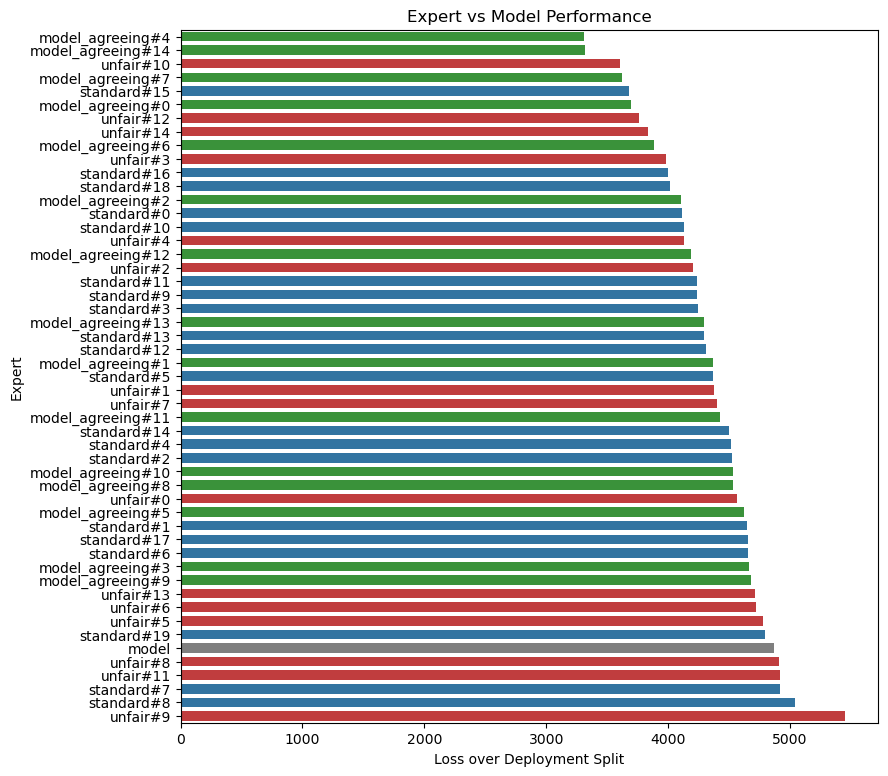

In [18]:
costs_over_all_cases = pd.DataFrame(index = exp_list + ['model'], columns = ['cost'])
lam = ml_model_threshold/(1-ml_model_threshold)
for expert in exp_list:
    fn = (1 - exp_pred_lp[expert])
    fp = exp_pred_ln[expert]

    costs_over_all_cases.loc[expert, 'cost'] = fn.sum() + fp.sum()*lam

mod_fn = 1- model_pred_lp
mod_fp = model_pred_ln
costs_over_all_cases.loc['model', 'cost'] = mod_fn.sum() + mod_fp.sum()*lam

costs_over_all_cases.reset_index(inplace=True)

for expert in costs_over_all_cases['index']:
    if expert.split('#')[0] == 'regular':
        costs_over_all_cases.replace(to_replace=expert, value= 'standard#' + expert.split('#')[1], inplace=True)


costs_over_all_cases.sort_values(by = 'cost', inplace = True)

groups = []
for expert in costs_over_all_cases['index'].to_list():
    if expert == 'model':
        groups.append('C7')
    else:
        if expert.split('#')[0] == 'standard':
            groups.append('C0')
        if expert.split('#')[0] == 'model_agreeing':
            groups.append('C2')
        if expert.split('#')[0] == 'unfair':
            groups.append('C3')

f, ax = plt.subplots(figsize=(9, 9))

sns.barplot(data = costs_over_all_cases, orient = 'h', y = 'index', x = 'cost', palette=groups, width = 0.7)
plt.xlabel("Loss over Deployment Split")
plt.ylabel("Expert")
plt.title('Expert vs Model Performance')
plt.savefig("Loss_over_deployment.pdf", format="pdf", bbox_inches="tight")


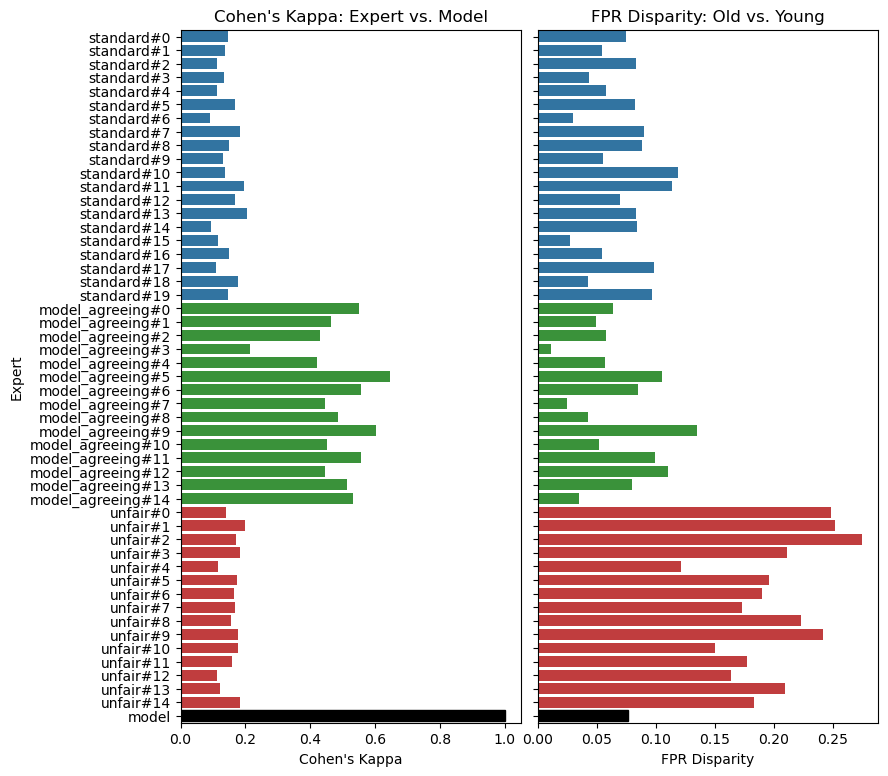

In [19]:
from sklearn.metrics import cohen_kappa_score
CK_model = pd.DataFrame(index = exp_pred.columns.to_list(), columns = ['expert', 'ck'])
CK_model['expert'] = exp_pred.columns.to_list()
for expert in exp_pred.columns:
    CK_model.loc[expert, 'ck'] = cohen_kappa_score(exp_pred[expert], model_pred)


CK_model.loc['model', 'ck'] = 1
CK_model.loc['model', 'expert'] = 'model'
temp = fpr_disparity.reset_index().loc[:,['index', 'disparity_deployment']]
temp.loc[50] = ['model', ml_model_fpr_diff]

for expert in CK_model['expert']:
    if expert.split('#')[0] == 'regular':
        CK_model.replace(to_replace=expert, value= 'standard#' + expert.split('#')[1], inplace=True)
for expert in temp['index']:
    if expert.split('#')[0] == 'regular':
        temp.replace(to_replace=expert, value= 'standard#' + expert.split('#')[1], inplace=True)

a = temp['index'].to_list()
groups = []
for expert in a:
    if expert == 'model':
        groups.append('C7')
    else:
        if expert.split('#')[0] == 'standard':
            groups.append('C0')
        if expert.split('#')[0] == 'model_agreeing':
            groups.append('C2')
        if expert.split('#')[0] == 'unfair':
            groups.append('C3')

f, ax = plt.subplots(1,2, figsize=(9, 9), sharey = True)

sns.barplot(ax = ax[0], data = CK_model, orient = 'h', y = 'expert', x = 'ck', palette = groups)
for bar in ax[0].patches:
    if bar.get_width() == 1:
        bar.set_color('black')    

ax[0].set_title("Cohen's Kappa: Expert vs. Model")
ax[0].set_xlabel("Cohen's Kappa")
ax[0].set_ylabel('Expert')

sns.barplot(ax = ax[1], data = temp, orient = 'h', y = 'index', x = 'disparity_deployment', palette = groups).set(ylabel = None)
for bar in ax[1].patches:
    if bar.get_width() == ml_model_fpr_diff:
        bar.set_color('black')    

ax[1].set_title("FPR Disparity: Old vs. Young")
ax[1].set_xlabel("FPR Disparity")

plt.subplots_adjust(wspace=0.05, hspace=0)
    
plt.savefig("Cohen_Kappa.pdf", format="pdf", bbox_inches="tight")